In [ ]:
!pip install pycuda

Biblioteke

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import math
import random

PyCuda

In [ ]:
cuda_code = """
__global__ void copyImageToSharedMemory(unsigned char *globalImg, unsigned char *sharedImg, int width, int height, int channels) {
    extern __shared__ unsigned char s_img[];

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        for (int c = 0; c < channels; c++) {
            int global_index = (y * width + x) * channels + c;
            int shared_index = (threadIdx.y * blockDim.x + threadIdx.x) * channels + c;
            s_img[shared_index] = globalImg[global_index];
        }
    }
    __syncthreads();
}

__global__ void calculateImageEnergy(unsigned char *image, unsigned long long *energy, int width, int height, int channels) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    unsigned long long local_energy = 0;

    if (x < width && y < height) {
        int index = (y * width + x) * channels;
        if (x + 1 < width) {
            for (int c = 0; c < channels; c++) {
                local_energy += abs((int)image[index + c] - (int)image[index + c + channels]);
            }
        }
        if (y + 1 < height) {
            for (int c = 0; c < channels; c++) {
                local_energy += abs((int)image[index + c] - (int)image[index + c + width * channels]);
            }
        }
        atomicAdd(energy, local_energy);
    }
}

__device__ void swapPixels(unsigned char *image, int width, int height, int channels, int x1, int y1, int x2, int y2) {
    if (x1 < 0 || x1 >= width || y1 < 0 || y1 >= height || x2 < 0 || x2 >= width || y2 < 0 || y2 >= height) {
        return; // Izlazak iz funkcije ako su granice prekoračene
    }

    int index1 = (y1 * width + x1) * channels;
    int index2 = (y2 * width + x2) * channels;

    for (int c = 0; c < channels; c++) {
        unsigned char temp = image[index1 + c];
        image[index1 + c] = image[index2 + c];
        image[index2 + c] = temp;
    }
}

__device__ void calculateLocalEnergyChange(unsigned char *image, unsigned long long *energy, int width, int height, int channels, int x_pivot, int y_pivot, bool isRightNeighbor) {

    if (x_pivot < 0 || x_pivot >= width || y_pivot < 0 || y_pivot >= height) {
        return; // Izlazak iz funkcije ako su granice prekoračene
    }
    int x_start = max(0, x_pivot - 1);
    int y_start = max(0, y_pivot - 1);
    int x_end = min(width, x_pivot + (isRightNeighbor ? 3 : 2));
    int y_end = min(height, y_pivot + (isRightNeighbor ? 2 : 3));

    unsigned long long local_energy_before = 0;
    unsigned long long local_energy_after = 0;

    // Izračunavanje energije pre zamene
    for (int y = y_start; y < y_end; y++) {
        for (int x = x_start; x < x_end; x++) {
            int index = (y * width + x) * channels;
            for (int c = 0; c < channels; c++) {
                if (x + 1 < width) {
                    local_energy_before += abs((int)image[index + c] - (int)image[index + c + channels]);
                }
                if (y + 1 < height) {
                    local_energy_before += abs((int)image[index + c] - (int)image[index + c + width * channels]);
                }
            }
        }
    }

    // Izvršavanje zamene piksela
    if (isRightNeighbor) {
        for(int c = 0; c<channels; c++)
          swapPixels(image, width, height, c, x_pivot, y_pivot, x_pivot + 1, y_pivot);
    } else {
        for(int c = 0; c<channels; c++)
          swapPixels(image, width, height, c, x_pivot, y_pivot, x_pivot, y_pivot + 1);
    }

    for (int y = y_start; y < y_end; y++) {
        for (int x = x_start; x < x_end; x++) {
            int index = (y * width + x) * channels;
            for (int c = 0; c < channels; c++) {
                if (x + 1 < width) {
                    local_energy_after += abs((int)image[index + c] - (int)image[index + c + channels]);
                }
                if (y + 1 < height) {
                    local_energy_after += abs((int)image[index + c] - (int)image[index + c + width * channels]);
                }
            }
        }
    }

    // Izračunavanje promene energije i ažuriranje ukupne energije
    long long dE = local_energy_after - local_energy_before;
    if (dE != 0) {
        atomicAdd(energy, dE);
    }
}

__device__ unsigned int simpleRand(unsigned int seed) {
    // Parametri LCG generatora
    const unsigned int a = 1664525;
    const unsigned int c = 1013904223;
    return a * seed + c;
}

__global__ void simulatedAnnealing(unsigned char *image, unsigned long long *energy, int width, int height, int channels, float startingTemp, int maxIter) {
    __shared__ unsigned char sharedImg[32 * 32 * 3];

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    unsigned int randSeed = x + width * y;

    if (x < width && y < height) {
        for (int c = 0; c < channels; c++) {
            int index = (y * width + x) * channels + c;
            sharedImg[index] = image[index];
        }
    }
    __syncthreads();

    if (x < width - 1 && y < height) {
        for (int iter = 0; iter < maxIter; iter++) {
            // Generisanje nasumičnih koordinata
            randSeed = simpleRand(randSeed);
            int x_pivot = randSeed % width;
            int y_pivot = (randSeed / width) % height;
            bool isRightNeighbor = randSeed % 2 == 0;

            unsigned long long initial_energy = *energy;

            //Izračunavanje lokalne promene energije i direktno ažuriranje *energy
            calculateLocalEnergyChange(sharedImg, energy, width, height, channels, x_pivot, y_pivot, isRightNeighbor);

            long long dE = *energy - initial_energy;

            randSeed = simpleRand(randSeed);
            float randValue = (float)(randSeed % 1000) / 1000.0f;

            if (dE < 0 || randValue < exp(-dE / (startingTemp * (1.0f - (float)iter / maxIter)))) {
                atomicAdd(energy, dE);
            }
            __syncthreads();
        }
    }
}

__global__ void parallelOptimization(unsigned char *image, unsigned long long *energy, unsigned char *bestImages, unsigned long long *bestEnergies, int width, int height, int channels, float startingTemp, int maxIter) {
    int blockId = blockIdx.x;
    __shared__ unsigned char sharedImg[32 * 32 * 3];
    __shared__ unsigned long long sharedBestEnergy;

    if (threadIdx.x == 0 && threadIdx.y == 0) {
        sharedBestEnergy = ULLONG_MAX;
    }
    __syncthreads();

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    unsigned int randSeed = x + width * y;

    // Kopiranje slike u deljenu memoriju
    if (x < width && y < height) {
        for (int c = 0; c < channels; c++) {
            int index = (y * width + x) * channels + c;
            sharedImg[index] = image[index];
        }
    }
    __syncthreads();
    for (int iter = 0; iter < maxIter; iter++) {
    randSeed = simpleRand(randSeed);
    int x_pivot = randSeed % width;
    int y_pivot = (randSeed / width) % height;
    bool isRightNeighbor = randSeed % 2 == 0;

    unsigned long long initial_energy = *energy;

    //Izračunavanje lokalne promene energije i direktno ažuriranje *energy
    calculateLocalEnergyChange(sharedImg, energy, width, height, channels, x_pivot, y_pivot, isRightNeighbor);

    long long dE = *energy - initial_energy;

    if (dE < 0 || (randSeed % 1000) / 1000.0f < exp(-dE / (startingTemp * (1.0f - (float)iter / maxIter)))) {
        if (dE < 0) {
            atomicMin(&sharedBestEnergy, *energy);
        }

        if (threadIdx.x == 0 && threadIdx.y == 0 && sharedBestEnergy == *energy) {
            bestEnergies[blockId] = *energy;
            for (int i = 0; i < width * height * channels; i++) {
                bestImages[blockId * width * height * channels + i] = sharedImg[i];
            }
        }
    }
    __syncthreads();
  }
}
"""

In [ ]:
mod = SourceModule(cuda_code, options=['--ptxas-options=-v'])

copy_image_to_shared_memory = mod.get_function("copyImageToSharedMemory")
calculate_image_energy = mod.get_function("calculateImageEnergy")
simulated_annealing = mod.get_function("simulatedAnnealing")
parallel_optimization = mod.get_function("parallelOptimization")

height, width, channels = 32, 32, 3
block = (12, 1, 1)
grid = (1, 1, 1)
num_blocks = grid[0] * grid[1]

best_images_size = num_blocks * height * width * channels
best_images_gpu = cuda.mem_alloc(best_images_size)
best_energies = np.full(num_blocks, np.inf, dtype=np.uint64)
best_energies_gpu = cuda.mem_alloc(num_blocks * 8) # 8 bajtova po uint64
cuda.memcpy_htod(best_energies_gpu, best_energies)

shared_mem_size = width * height * channels * np.dtype(np.uint8).itemsize

<ipython-input-3-f7dd6a2c5076>:1: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'parallelOptimization' for 'sm_75'
ptxas info    : Function properties for parallelOptimization
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 54 registers, 3088 bytes smem, 404 bytes cmem[0]
ptxas info    : Compiling entry function 'simulatedAnnealing' for 'sm_75'
ptxas info    : Function properties for simulatedAnnealing
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 50 registers, 3072 bytes smem, 388 bytes cmem[0]
ptxas info    : Compiling entry function 'calculateImageEnergy' for 'sm_75'
ptxas info    : Function properties for calculateImageEnergy
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 48 registers, 380 bytes cmem[0]
ptxas info    : Compiling entry function 'copyImageToSharedMemory' for

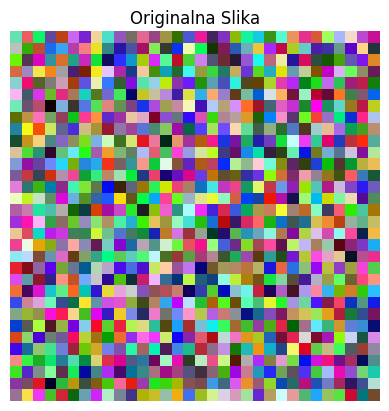

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


  0%|          | 0/10 [00:00<?, ?it/s]

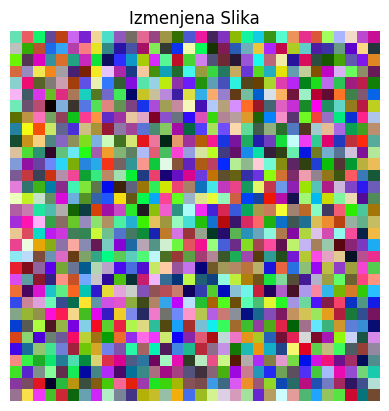

CUDA Performanse:
Vremena izvršavanja: 168.91643857955933
Energija pre: 6770
Energija posle: 1.844674406175545e+20


In [ ]:
startingTemp = 100.0
maxIter = 30_000_000
maxIter_per_thread = maxIter // (grid[0] * grid[1] * block[0] * block[1])

np.random.seed(42)
slika = np.random.randint(256, size=(height, width, channels), dtype=np.int16)

cuda_vremena = 0
cuda_energije_pre = 0
cuda_energije_posle = 0

plt.imshow(slika)
plt.title("Originalna Slika")
plt.axis('off')
plt.show()

slika_gpu = cuda.mem_alloc(slika.nbytes)
cuda.memcpy_htod(slika_gpu, slika)
energy_gpu = cuda.mem_alloc(64)

nergija = calculate_image_energy(slika_gpu, energy_gpu, np.int32(width), np.int32(height), np.int32(channels), block=block, grid=grid)
cuda.Context.synchronize()

energy_pre = np.empty(1, dtype=np.uint64)
cuda.memcpy_dtoh(energy_pre, energy_gpu)
cuda_energije_pre = energy_pre[0]

for iteration in tqdm(range(10)):
  t = iteration / maxIter
  temp = (1 - t) * startingTemp
  start = time.time()

  try:
      copy_image_to_shared_memory(slika_gpu, np.int32(width), np.int32(height), np.int32(channels), block=block, grid=grid, shared=shared_mem_size)
      cuda.Context.synchronize()

      simulated_annealing(slika_gpu, energy_gpu, np.int32(width), np.int32(height), np.int32(channels), np.float32(temp), np.int32(maxIter_per_thread), block=block, grid=grid)
      cuda.Context.synchronize()
  except cuda.LogicError as e:
      print("CUDA greška:", e)

  kraj = time.time()
  cuda_vremena += kraj - start

  calculate_image_energy(slika_gpu, energy_gpu, np.int32(width), np.int32(height), np.int32(channels), block=block, grid=grid)
  cuda.Context.synchronize()

  energy_posle = np.empty(1, dtype=np.uint64)
  cuda.memcpy_dtoh(energy_posle, energy_gpu)
  cuda_energije_posle += (energy_posle[0])

  izmenjena_slika = np.empty_like(slika)
  cuda.memcpy_dtoh(izmenjena_slika, slika_gpu)
  cuda.Context.synchronize()

plt.imshow(izmenjena_slika)
plt.title("Izmenjena Slika")
plt.axis('off')
plt.show()

print("CUDA Performanse:")
print("Vremena izvršavanja:", cuda_vremena)
print("Energija pre:", cuda_energije_pre)
print("Energija posle:", cuda_energije_posle)

cuda.Context.synchronize()

In [ ]:
startingTemp = 100.0
maxIter = 30_000_000
maxIter_per_thread = maxIter // (grid[0] * grid[1] * block[0] * block[1])

np.random.seed(42)
slika = np.random.randint(256, size=(height, width, channels), dtype=np.int16)
cuda_vremena = 0
cuda_energije_pre = []
cuda_energije_posle = []
block2 = (12,4,1)
grid = (1,1,1)

plt.imshow(slika)
plt.title("Originalna Slika")
plt.axis('off')
plt.show()

slika_gpu = cuda.mem_alloc(slika.nbytes)
cuda.memcpy_htod(slika_gpu, slika)
energy_gpu = cuda.mem_alloc(64)

for iteration in tqdm(range(10)):
  t = iteration / maxIter
  temp = (1 - t) * startingTemp

  energija = calculate_image_energy(slika_gpu, energy_gpu, np.int32(width), np.int32(height), np.int32(channels), block=block, grid=grid)
  cuda.Context.synchronize()

  energy_pre = np.empty(1, dtype=np.uint64)
  cuda.memcpy_dtoh(energy_pre, energy_gpu)
  cuda_energije_pre.append(energy_pre[0])

  start = time.time()

  try:
      copy_image_to_shared_memory(slika_gpu, np.int32(width), np.int32(height), np.int32(channels), block=block, grid=grid, shared=shared_mem_size)
      cuda.Context.synchronize()

      parallel_optimization(slika_gpu, energy_gpu, best_images_gpu, best_energies_gpu, np.int32(width), np.int32(height), np.int32(channels), np.float32(temp), np.int32(maxIter_per_thread), block=block, grid=grid)
      cuda.Context.synchronize()
  except cuda.LogicError as e:
      print("CUDA greška:", e)

  kraj = time.time()
  cuda_vremena += kraj - start

  calculate_image_energy(slika_gpu, energy_gpu, np.int32(width), np.int32(height), np.int32(channels), block=block, grid=grid)
  cuda.Context.synchronize()

  energy_posle = np.empty(1, dtype=np.uint64)
  cuda.memcpy_dtoh(energy_posle, energy_gpu)
  cuda_energije_posle.append(energy_posle[0])

  best_energies = np.empty(num_blocks, dtype=np.uint64)
  cuda.memcpy_dtoh(best_energies, best_energies_gpu)

  best_images = np.empty((num_blocks, height, width, channels), dtype=np.uint8)
  cuda.memcpy_dtoh(best_images, best_images_gpu)

  izmenjena_slika = np.empty_like(slika)
  cuda.memcpy_dtoh(izmenjena_slika, slika_gpu)
  cuda.Context.synchronize()

plt.imshow(izmenjena_slika)
plt.title("Izmenjena Slika")
plt.axis('off')
plt.show()

print("CUDA Performanse:")
print("Vremena izvršavanja:", cuda_vremena)

cuda.Context.synchronize()

Python

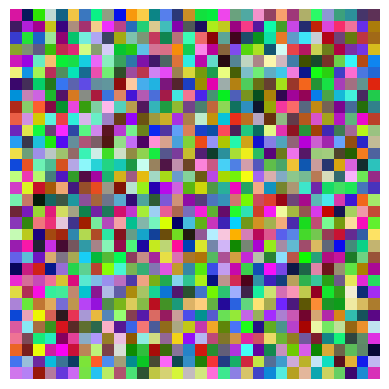

  0%|          | 0/30000000 [00:00<?, ?it/s]

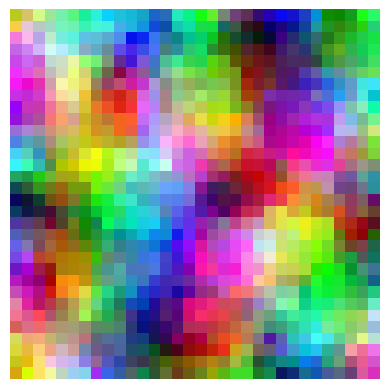

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import math
import random


def energy(image):
  distances = np.zeros_like(image, dtype=np.float32)
  distances[:, :-1, :] += np.abs(image[:, :-1, :] - image[:, 1:, :])
  distances[:-1, :, :] += np.abs(image[:-1, :, :] - image[1:, :, :])
  return distances.sum()


def energy_delta(image, image2, src, tgt):
  row_low = max(0, src[0] - 1)
  row_high = tgt[0] + 2
  col_low = max(0, src[1] - 1)
  col_high = tgt[1] + 2
  old = energy(image[row_low:row_high, col_low:col_high])
  new = energy(image2[row_low:row_high, col_low:col_high])
  return new - old

moves = np.array([(0, 1), (1, 0)], dtype=np.uint8)


image = np.random.randint(0, 255, (32, 32, 3), dtype=np.int16)
image2 = np.copy(image)
current_energy = energy(image)

plt.imshow(image)
plt.axis('off')
plt.show()

# ---------------
starting_temp = 100
total = 30_000_000
swaps = 0

for iteration in tqdm(range(total)):
  t = iteration / total
  temp = (1 - t) * starting_temp
  src = np.random.randint(0, image.shape[0]-1, 2)
  move = moves[np.random.randint(0, 2)]
  tgt = src + move
  image2[src[0], src[1]] = image[tgt[0], tgt[1]]
  image2[tgt[0], tgt[1]] = image[src[0], src[1]]

  dE = energy_delta(image, image2, src, tgt)
  if dE < 0 or random.random() < np.exp2(-dE/temp):
    image[src[0], src[1]] = image2[src[0], src[1]]
    image[tgt[0], tgt[1]] = image2[tgt[0], tgt[1]]
    # current_energy = new_energy
    current_energy += dE
    swaps += 1
  else:
    image2[src[0], src[1]] = image[src[0], src[1]]
    image2[tgt[0], tgt[1]] = image[tgt[0], tgt[1]]

# ---------------

plt.imshow(image)
plt.axis('off')
plt.show()